# Strategy Backtesting

This notebook evaluate the performance of our momentum based strategy using historical market data to simulate real-world execution.

In [ ]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import Gateway as gw # Gateway class reads and feeds market data into the system incrementally
import MatchingEngine as me # MatchingEngine class simulates order matching and execution outcomes
import OrderBook as obk # OrderBook class manages orders and trades
import Momentum as mm # Momentum strategy implementation
import NewStrategy as nm
import OrderManager as om  # OrderManager class for order validation and management
import uuid
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Data Acquisition and Setup 

In [2]:
fp = 'cleaned/NVDA_7d.csv'
streamer = gw.Gateway(fp)
engine = me.MatchingEngine()
book = obk.OrderBook()
order_manager = om.OrderManager()

### Simulation Execution 

- Feed historical data through the Gateway to simulate a live environment.
- Generate and process orders based on strategy signals.
- Use the Matching Engine to simulate fills, partial fills, and cancellations.

In [3]:
df = pd.read_csv(fp)
df.set_index('Datetime', inplace=True)
strat = mm.Momentum(df)
signals = strat.run()

newstrat = nm.NewStrategy(df)
newsignals = newstrat.run()

market_data = streamer.stream_data()
print(market_data)

print(signals)
print(newsignals)

# print(df)

{'2025-11-10 15:19:00+00:00': {'Ticker': 'NVDA', 'Price': 195.7447967529297}, '2025-11-10 15:20:00+00:00': {'Ticker': 'NVDA', 'Price': 195.91000366210932}, '2025-11-10 15:21:00+00:00': {'Ticker': 'NVDA', 'Price': 196.1849975585937}, '2025-11-10 15:22:00+00:00': {'Ticker': 'NVDA', 'Price': 196.0200042724609}, '2025-11-10 15:23:00+00:00': {'Ticker': 'NVDA', 'Price': 196.22000122070312}, '2025-11-10 15:24:00+00:00': {'Ticker': 'NVDA', 'Price': 196.4799041748047}, '2025-11-10 15:25:00+00:00': {'Ticker': 'NVDA', 'Price': 196.7400054931641}, '2025-11-10 15:26:00+00:00': {'Ticker': 'NVDA', 'Price': 196.78990173339844}, '2025-11-10 15:27:00+00:00': {'Ticker': 'NVDA', 'Price': 196.85910034179688}, '2025-11-10 15:28:00+00:00': {'Ticker': 'NVDA', 'Price': 196.9349975585937}, '2025-11-10 15:29:00+00:00': {'Ticker': 'NVDA', 'Price': 196.6199951171875}, '2025-11-10 15:30:00+00:00': {'Ticker': 'NVDA', 'Price': 196.54010009765625}, '2025-11-10 15:31:00+00:00': {'Ticker': 'NVDA', 'Price': 196.579895019

In [4]:
def compute_position_size(price, risk_per_trade=0.0001, base_stop_loss=0.01, min_size=1):
    risk_amount = order_manager.available_capital * risk_per_trade
    risk_per_share = price * base_stop_loss
    if risk_per_share <= 0:
        return min_size
    shares = int(risk_amount / risk_per_share)

    size = max(min_size, shares)
    return size

In [5]:
pnls = {}  # key = time, value = pnl at that time 

for time in signals.keys():
    dt_time = pd.to_datetime(time)
    order_id = f"order_{time}_{uuid.uuid4()}" 
    price = market_data[time]['Price']
    sig = signals[time]
    size = compute_position_size(price)
    side = 'Buy' 
    
    if sig == -1: 
        side = 'Sell'
    elif sig == 0:
        side = 'Hold'
    
    print(dt_time, order_id, price, size, side, sig)

    order = obk.Order(order_id, price, size, side, dt_time)
    # print(order.size)
    
    validation_response = order_manager.validate_order(order)

    if validation_response[0] == False:
        print(f"Order {order.order_id} is invalid: {validation_response}")
        continue


    book.add(order)
    # print(f"Added order: {order.order_id}, Side: {order.side}, Price: {order.price}, Size: {order.size}, Time: {order.time}")
    book.process(order)
    streamer.log_order(order, action="Added")
    order_manager.record_order(order)

    pnl = order_manager.available_capital - (order_manager.current_position * order.price)
    pnls[dt_time] = pnl 

2025-11-10 15:19:00+00:00 order_2025-11-10 15:19:00+00:00_39df0548-57c2-41ca-af91-518cf5a32737 195.7447967529297 5 Buy 1
Order order_2025-11-10 15:19:00+00:00_39df0548-57c2-41ca-af91-518cf5a32737 added to book.
2025-11-10 15:20:00+00:00 order_2025-11-10 15:20:00+00:00_b2a24c30-1e4a-411b-bb2c-7f5d6c851640 195.91000366210932 5 Buy 1
Order order_2025-11-10 15:20:00+00:00_b2a24c30-1e4a-411b-bb2c-7f5d6c851640 added to book.
2025-11-10 15:21:00+00:00 order_2025-11-10 15:21:00+00:00_066542c0-290c-47ff-8275-db71a2918589 196.1849975585937 4 Buy 1
Order order_2025-11-10 15:21:00+00:00_066542c0-290c-47ff-8275-db71a2918589 added to book.
2025-11-10 15:22:00+00:00 order_2025-11-10 15:22:00+00:00_6f847276-c0e4-4dac-b348-e20ece128a96 196.0200042724609 4 Buy 1
Order order_2025-11-10 15:22:00+00:00_6f847276-c0e4-4dac-b348-e20ece128a96 added to book.
2025-11-10 15:23:00+00:00 order_2025-11-10 15:23:00+00:00_839c3119-56d2-407e-bc18-f8e2ce9f5f16 196.22000122070312 4 Buy 1
Order order_2025-11-10 15:23:00+0

### Performance Tracking

- Record executed trades, timestamps, prices, and volumes.
- Calculate key metrics: P&L, Sharpe ratio, drawdown, win/loss ratio, etc.

In [6]:
def display_stats (market_data):
    pnl = order_manager.available_capital - order_manager.current_position * market_data[order_manager.current_minute]['Price']
    print(f"Initial Capital: {order_manager.initial_capital}")
    print(f"Available Capital: {order_manager.available_capital}")
    print(f"Current Position Size: {order_manager.current_position}")
    print(f"Total Orders Executed: {len(order_manager.orders_executed)}")
    print(f"PnL: {pnl}")
    return pnl

### Reporting 

- Visualize equity curve, trade distribution, and performance statistics.
- Compare strategy variants and parameter sensitivity.

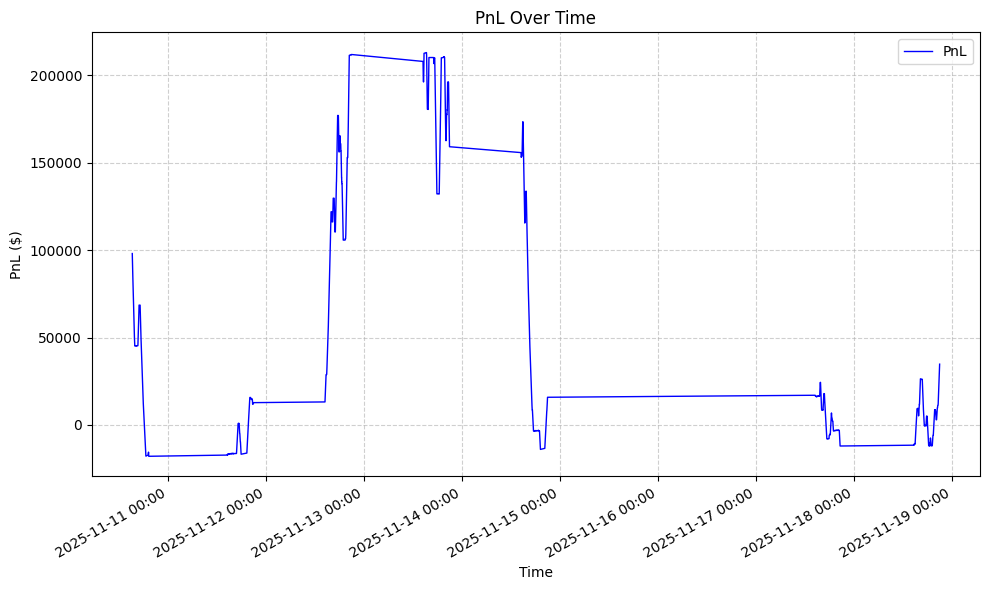

In [ ]:
sorted_pnl_items = sorted(pnls.items()) 
pnl_times, pnl_values = zip(*sorted_pnl_items)

plt.figure(figsize=(10, 6))
plt.plot(pnl_times, pnl_values, label='PnL', color='blue', linewidth=1)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gcf().autofmt_xdate() # Rotation
plt.xlabel('Time')
plt.ylabel('PnL ($)')
plt.title('PnL Over Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


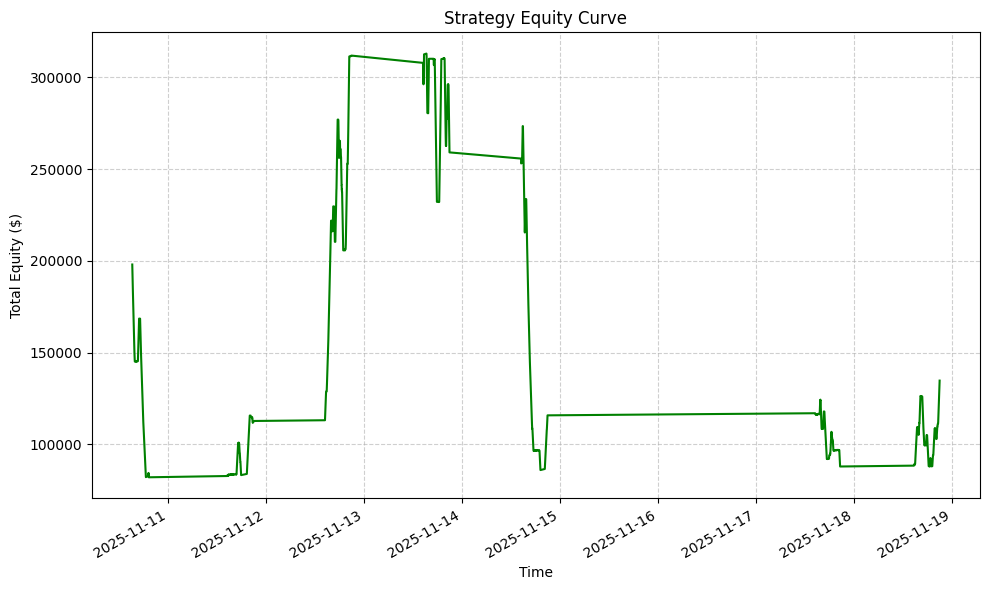

In [ ]:
def generate_equity_curve(): 
    if not pnls:
        print("No PnL data to plot.")
        return pd.DataFrame()

    equity_curve = pd.DataFrame(list(pnls.items()), columns=['Time', 'PnL'])
    equity_curve['Time'] = pd.to_datetime(equity_curve['Time'])
    
    equity_curve.sort_values('Time', inplace=True)
    equity_curve.set_index('Time', inplace=True)
    
    equity_curve['Equity'] = equity_curve['PnL'] + order_manager.initial_capital
    
    plt.figure(figsize=(10, 6))
    equity_curve['Equity'].plot(title='Strategy Equity Curve', color='green')
    plt.ylabel('Total Equity ($)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return equity_curve

df_equity = generate_equity_curve()

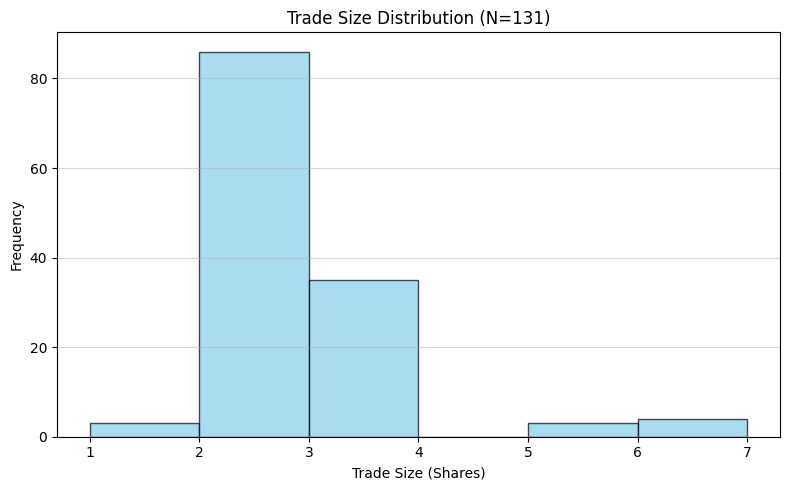

In [ ]:
def find_trade_distribution():
    trade_sizes = [order.size for order in order_manager.orders_executed if order.size > 0]
    
    if not trade_sizes:
        print("No executed trades to plot.")
        return

    plt.figure(figsize=(8, 5))
    
    max_size = max(trade_sizes)
    bins = range(1, max_size + 2) if max_size < 20 else 20
    
    plt.hist(trade_sizes, bins=bins, edgecolor='black', color='skyblue', alpha=0.7)
    
    plt.xlabel('Trade Size (Shares)')
    plt.ylabel('Frequency')
    plt.title(f'Trade Size Distribution (N={len(trade_sizes)})')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

find_trade_distribution()

In [ ]:
def performance_statistics():
    trades_pnl = []
    current_qty = 0
    avg_entry_price = 0.0

    for order in order_manager.orders_executed:
        if order.side == 'Buy':
            total_cost = (current_qty * avg_entry_price) + (order.size * order.price)
            current_qty += order.size
            if current_qty > 0:
                avg_entry_price = total_cost / current_qty
                
        elif order.side == 'Sell':
            trade_pnl = (order.price - avg_entry_price) * order.size
            trades_pnl.append(trade_pnl)
            
            current_qty = max(0, current_qty - order.size)
        
            if current_qty == 0:
                avg_entry_price = 0

    # --- Statistics Calculation ---
    total_closed_trades = len(trades_pnl)
    winning_trades = [pnl for pnl in trades_pnl if pnl > 0]
    losing_trades = [pnl for pnl in trades_pnl if pnl <= 0]

    win_rate = len(winning_trades) / total_closed_trades if total_closed_trades > 0 else 0
    
    avg_win = np.mean(winning_trades) if winning_trades else 0
    avg_loss = np.mean(losing_trades) if losing_trades else 0
    total_pnl = sum(trades_pnl)

    print("--- Performance Report ---")
    print(f"Total Closed Trades: {total_closed_trades}")
    print(f"Winning Trades:      {len(winning_trades)}")
    print(f"Losing Trades:       {len(losing_trades)}")
    print(f"Win Rate:            {win_rate:.2%}")
    print(f"Average Win ($):     ${avg_win:.2f}")
    print(f"Average Loss ($):    ${avg_loss:.2f}")
    print(f"Total PnL ($):       ${total_pnl:.2f}")

performance_statistics()


--- Performance Report ---
Total Closed Trades: 1268
Winning Trades:      131
Losing Trades:       1137
Win Rate:            10.33%
Average Win ($):     $458.69
Average Loss ($):    $0.00
Total PnL ($):       $60088.76
